In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json
from pandas.io.json import json_normalize

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

%matplotlib inline
from cv2 import cv2

In [3]:
from torch import optim

In [4]:
#!git clone https://github.com/ultralytics/yolov5
#!pip install -qr ./yolov5/requirements.txt

In [5]:
from yolov5 import train, val, detect

# Load data

In [22]:
if False:
    os.chdir('data')
else:
    os.chdir('/media/danil-pass123/Новый том/DataSet')
!ls

archives			     not_found.txt
dataset				     processed_test.csv
dataset.zip			     processed_train.csv
data.yaml			     runs
gps_locations.json		     test
iwildcam2022_mdv4_detections.json    train
iwildcam2022_test_information.json   train1
iwildcam2022_train_annotations.json  train_sequence_counts.csv
label1223.txt			     yolov5
logger.txt			     yolov5s.pt


In [7]:
#def get_label(filename: str, labels: list[dict]):
def get_label(filename, labels):
    row = next((x for x in labels if filename == x['file']), [None])
    if row is None:
        return row
    detections = row['detections']
    filtered_detections = list(filter(lambda x: x['category'] == '1' and x['conf'] > 0.5, detections))
    bboxes = list(map(lambda x: x['bbox'], filtered_detections))
    return json.dumps(bboxes)

To make a pytorch dataset we extract filenames from json file. Extracting label was a harder, because we need to extract one json and for every record we need to take filename and match it with record's filename from another json(basically it is similar to SQL `JOIN ON`), taking needed fields, filter by 'category' and confidence, and converting it to json string, for easy reading and saving. We save a progress in csv file, so we can always read it, instead of executing everything again. Dataset consist of taking image paths from our csv, reading it, resizing it, converting to rgb, and converting it to tensors. Right now dataset consist of images(that's why we use results from a pretrained model, as they are written for images, instead of `train_sequence_counts`), later it may change to sequences of images.

In [8]:
#def get_data(images_json_path: str, labels_json_path: str, train: bool = True):
def get_data(images_json_path, labels_json_path, train = True):
    d = None
    with open(labels_json_path) as f:
        d = json.load(f)
    labels = d['images']

    with open(images_json_path) as f:
        d = json.load(f)
    images = json_normalize(data=d['images'],
                   meta=['seq_num_frames', 'location', 'datetime', 'id', 'seq_id', 'width', 'height', 'file_name', 'sub_location', 'seq_frame_num'])
    # annotations_df = json_normalize(data=d['annotations'],
    #                              meta=['id', 'image_id', 'category_id'])
    # categories_df = json_normalize(data=d['categories'],
    #                             meta=['id', 'name'])

    # return get_label('train/' + images.iloc[0]['file_name'], labels)
    get_path = lambda x: get_label(filename=(('train/' if train else 'test/') + x['file_name']), labels=labels)
    images['box'] = images.apply(get_path, axis=1)
    return images

In [8]:
#df = get_data('iwildcam2022_train_annotations.json', 'iwildcam2022_mdv4_detections.json', train=True)
#df = get_data('iwildcam2022_test_information.json', 'iwildcam2022_mdv4_detections.json', train=False)

/tmp/ipykernel_6971/2537529292.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  images = json_normalize(data=d['images'],


In [10]:
#df.head(5)

seq_num_frames  location                 datetime  \
0               6         3  2013-06-05 05:44:19.000   
1               6         3  2013-06-05 05:44:20.000   
2               6         3  2013-06-05 05:44:21.000   
3               6         3  2013-06-05 05:44:22.000   
4               6         3  2013-06-05 05:44:23.000   

                                     id                                seq_id  \
0  8b02698a-21bc-11ea-a13a-137349068a90  30048d32-7d42-11eb-8fb5-0242ac1c0002   
1  8e5b81de-21bc-11ea-a13a-137349068a90  30048d32-7d42-11eb-8fb5-0242ac1c0002   
2  8c6be0e4-21bc-11ea-a13a-137349068a90  30048d32-7d42-11eb-8fb5-0242ac1c0002   
3  8fdf7998-21bc-11ea-a13a-137349068a90  30048d32-7d42-11eb-8fb5-0242ac1c0002   
4  96093c50-21bc-11ea-a13a-137349068a90  30048d32-7d42-11eb-8fb5-0242ac1c0002   

   ...  height                                 file_name sub_location  \
0  ...    1080  8b02698a-21bc-11ea-a13a-137349068a90.jpg          0.0   
1  ...    1080  8e5b81de-21bc-11ea-a13a-137349068a90.jpg          0.0   
2  ...    1080  8c6be0e4-21bc-11ea-a13a-137349068a90.jpg          0.0   
3  ...    1080  8fdf7998-21bc-11ea-a13a-137349068a90.jpg          0.0   
4  ...    1080  96093c50-21bc-11ea-a13a-137349068a90.jpg          0.0   

   seq_frame_num                             box  
0              0      [[0, 0.091, 0.983, 0.876]]  
1              1  [[0.193, 0.261, 0.803, 0.714]]  
2              2  [[0.717, 0.412, 0.282, 0.558]]  
3              3  [[0.772, 0.474, 0.226, 0.504]]  
4              4   [[0.862, 0.539, 0.136, 0.43]]  

[5 rows x 11 columns]

In [9]:
#df.to_csv('processed_train.csv', sep='\t')
#df.to_csv('processed_test.csv', sep='\t')

In [ ]:
df = pd.read_csv('processed_train.csv', sep='\t', index_col=0)
df.head(5)

In [17]:
df = pd.read_csv('processed_test.csv', sep='\t', index_col=0)
df.head(5)

height                                    id  \
0    1024  8b31d3be-21bc-11ea-a13a-137349068a90   
1    1024  8cf202be-21bc-11ea-a13a-137349068a90   
2    1024  8a87e62e-21bc-11ea-a13a-137349068a90   
3    1024  8e6994f4-21bc-11ea-a13a-137349068a90   
4    1024  948b29e2-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  ...  \
0  a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280  ...   
1  a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280  ...   
2  a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280  ...   
3  a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280  ...   
4  a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280  ...   

                                  file_name seq_frame_num  seq_num_frames  \
0  8b31d3be-21bc-11ea-a13a-137349068a90.jpg             0              10   
1  8cf202be-21bc-11ea-a13a-137349068a90.jpg             1              10   
2  8a87e62e-21bc-11ea-a13a-137349068a90.jpg             2              10   
3  8e6994f4-21bc-11ea-a13a-137349068a90.jpg             3              10   
4  948b29e2-21bc-11ea-a13a-137349068a90.jpg             4              10   

   sub_location                         box  
0           NaN   [[0, 0.55, 0.558, 0.438]]  
1           NaN  [[0, 0.557, 0.684, 0.431]]  
2           NaN  [[0, 0.418, 0.712, 0.581]]  
3           NaN  [[0, 0.402, 0.673, 0.584]]  
4           NaN  [[0, 0.547, 0.693, 0.439]]  

[5 rows x 11 columns]

In [19]:
#def parse_bbox_tuple(labels: tuple[str]):
def parse_bbox_tuple(labels):
    return [json.loads(l) for l in labels]

class CustomDataset(Dataset):
    def __init__(self, df, train: bool = True):
        self.labels = df['box']
        self.images = df['file_name']
        self.train = train

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = ('train/' if self.train else 'test/') + self.images.iloc[idx]
        label = self.labels.iloc[idx]
        return image, label

BATCH_SIZE = 10

# full_hd_df = df[df["width"]==1920]
hd_df = df[(df["height"]==720) & (df["width"]==1280)]

#train_data = CustomDataset(hd_df, train=True)
#train_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = CustomDataset(hd_df, train=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [18]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/denis/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-25 Python-3.10.5 torch-1.12.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Performance measurements

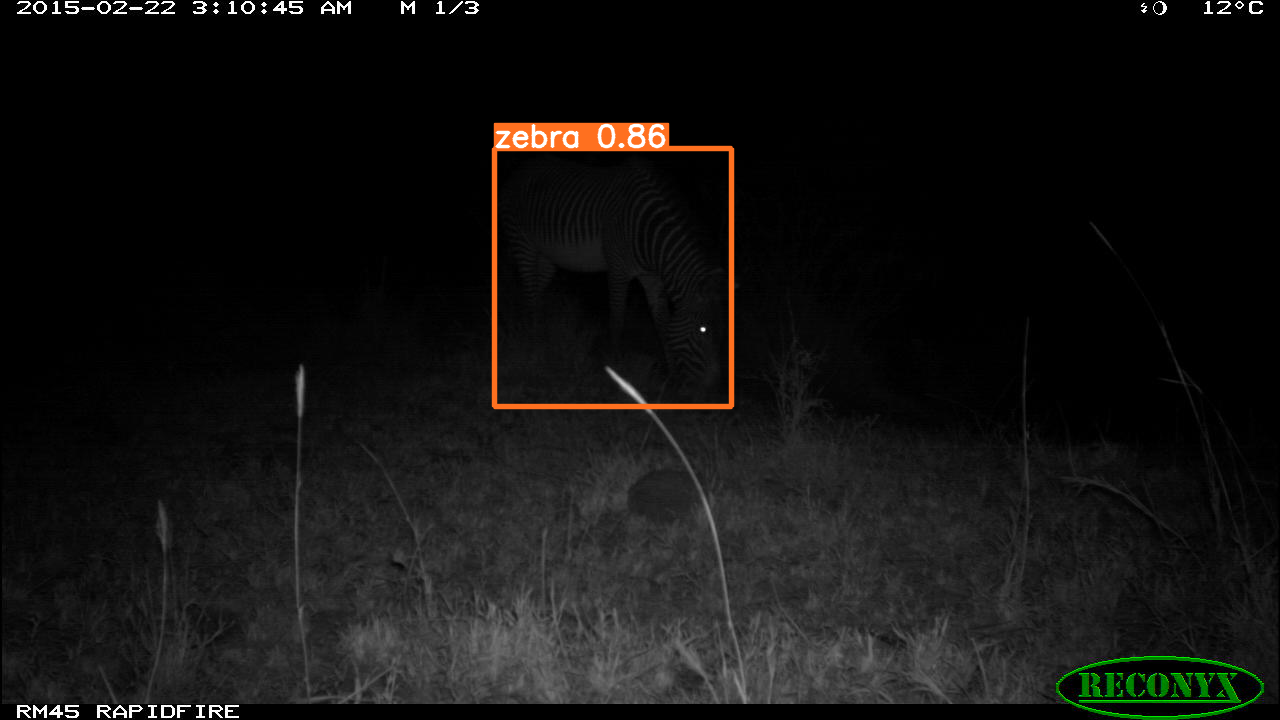

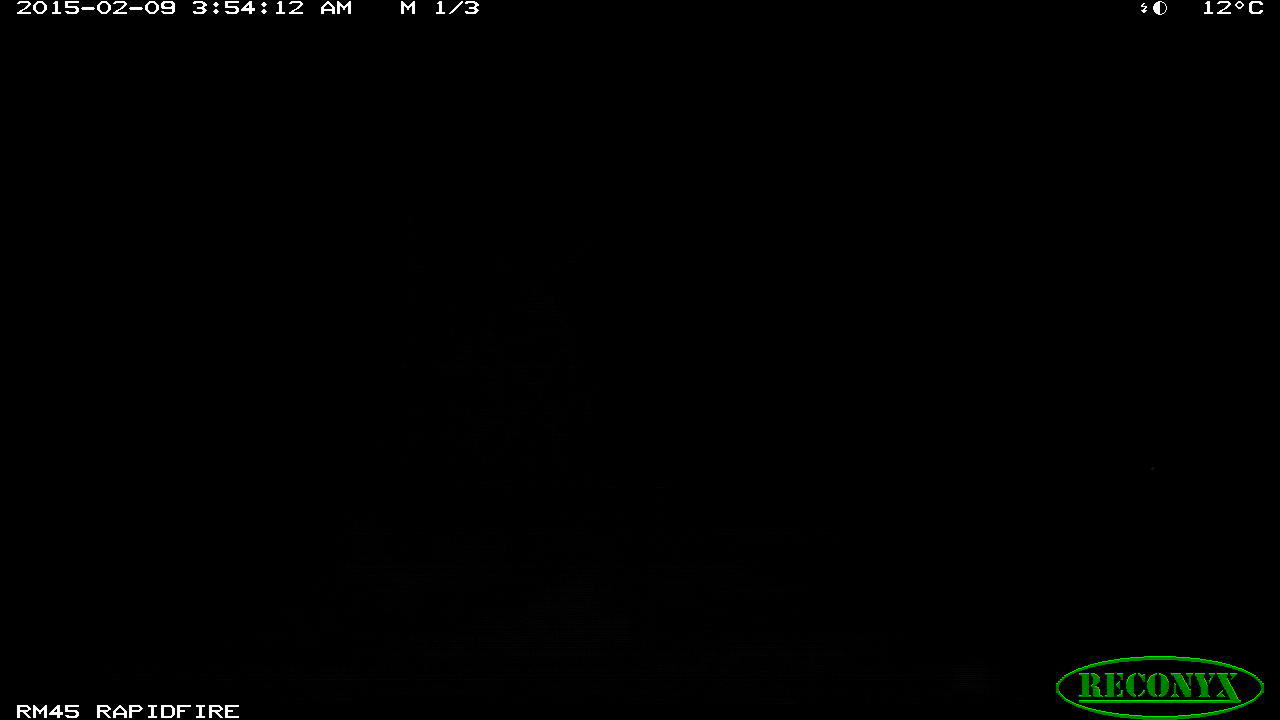

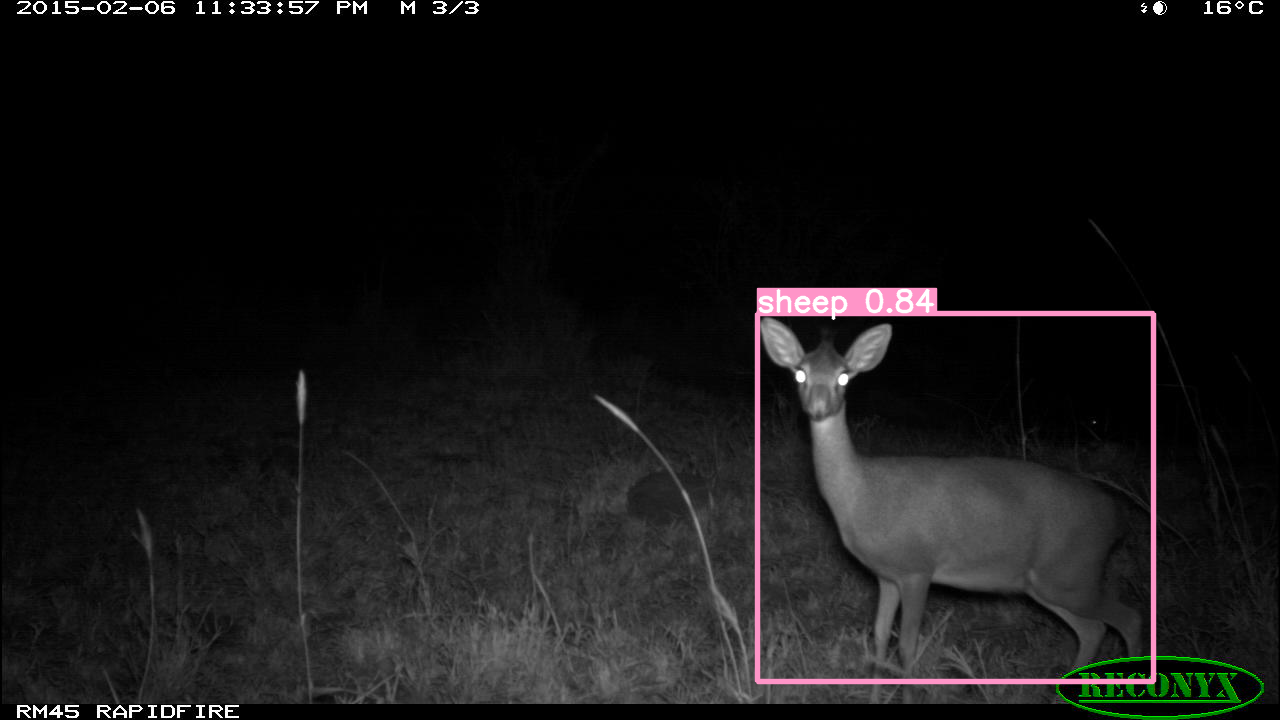

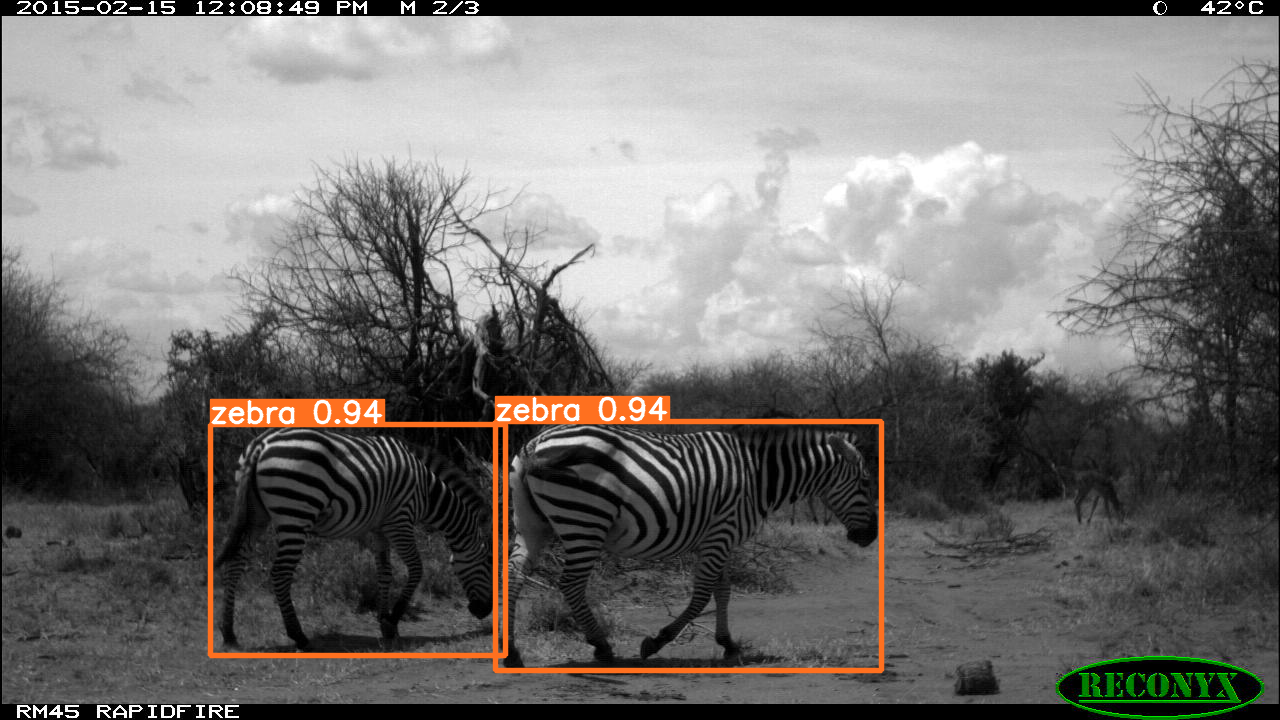

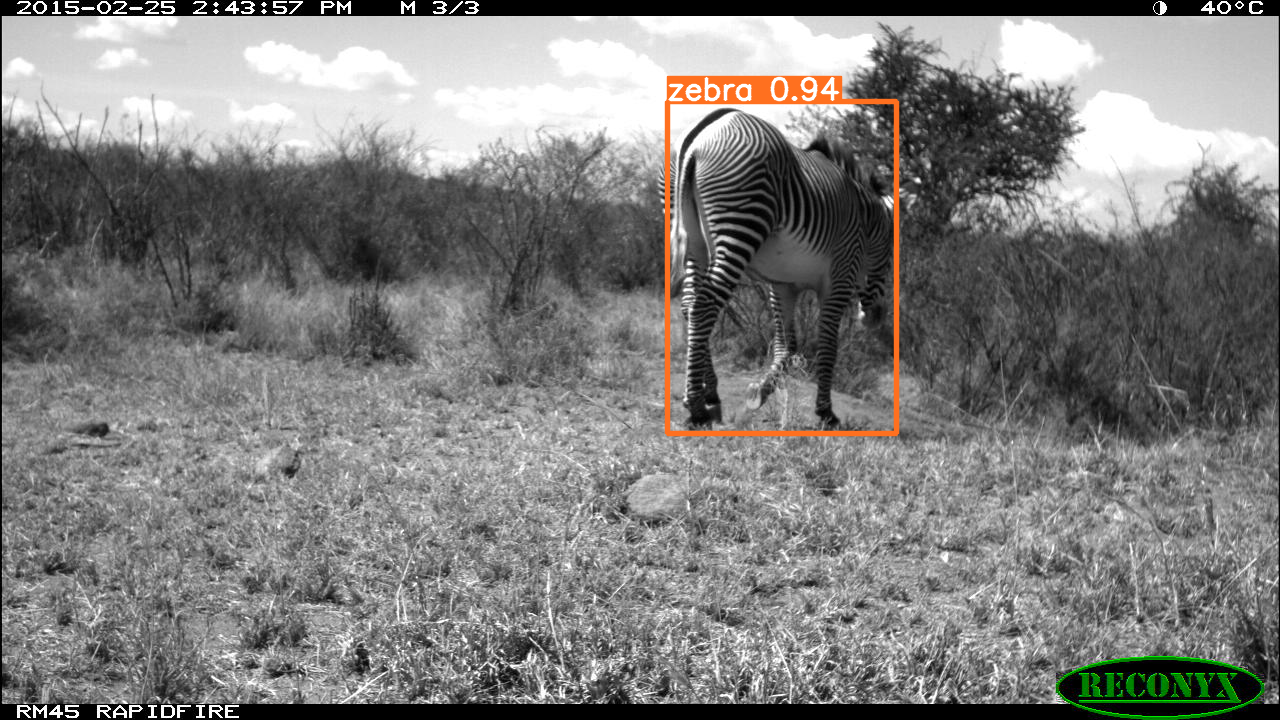

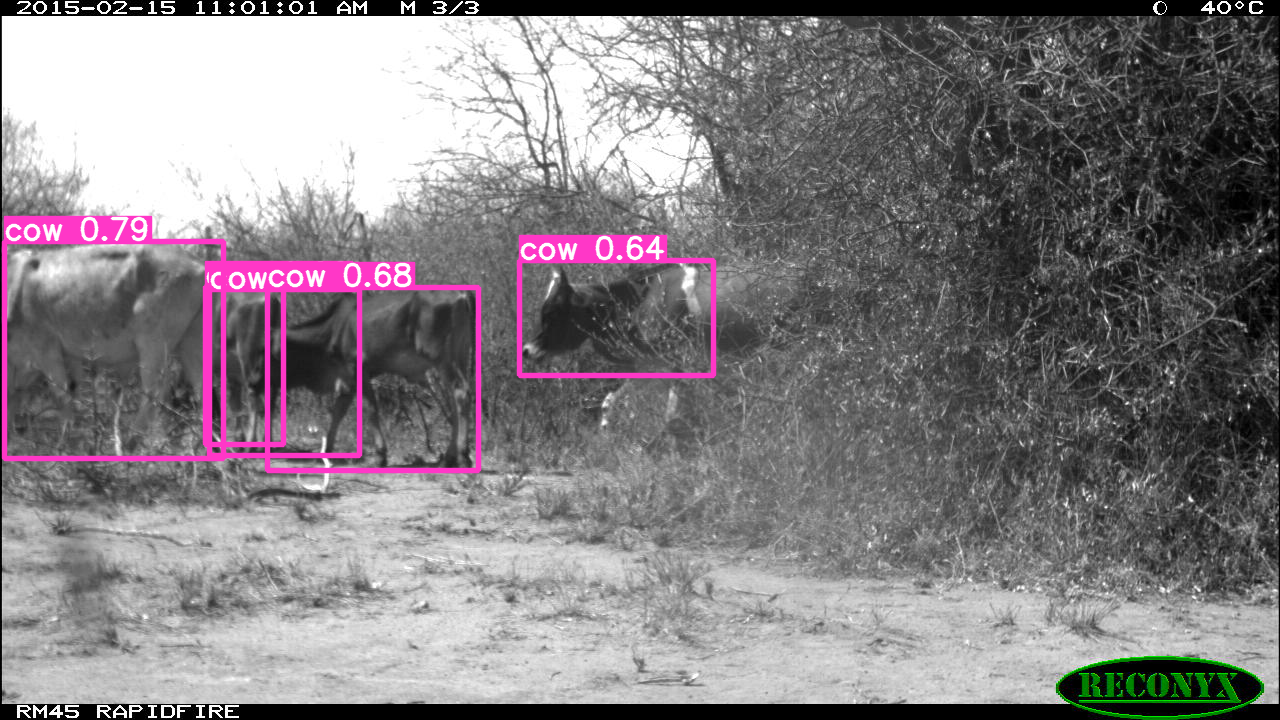

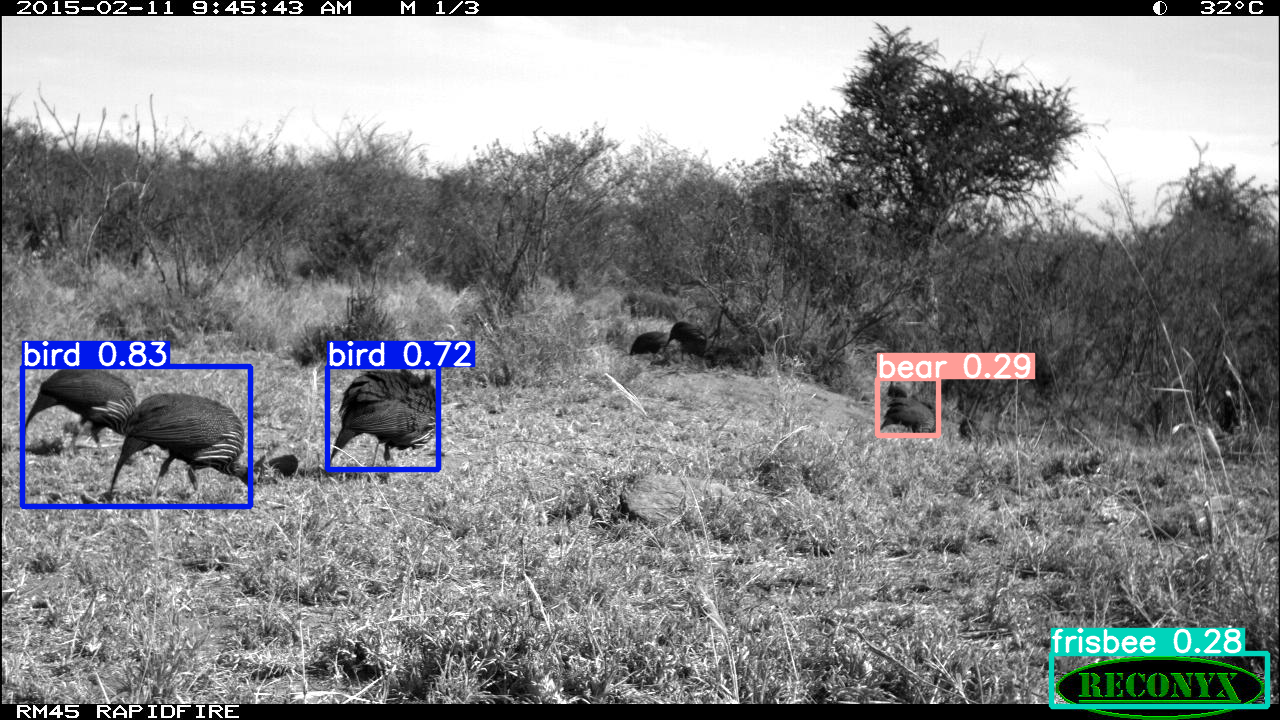

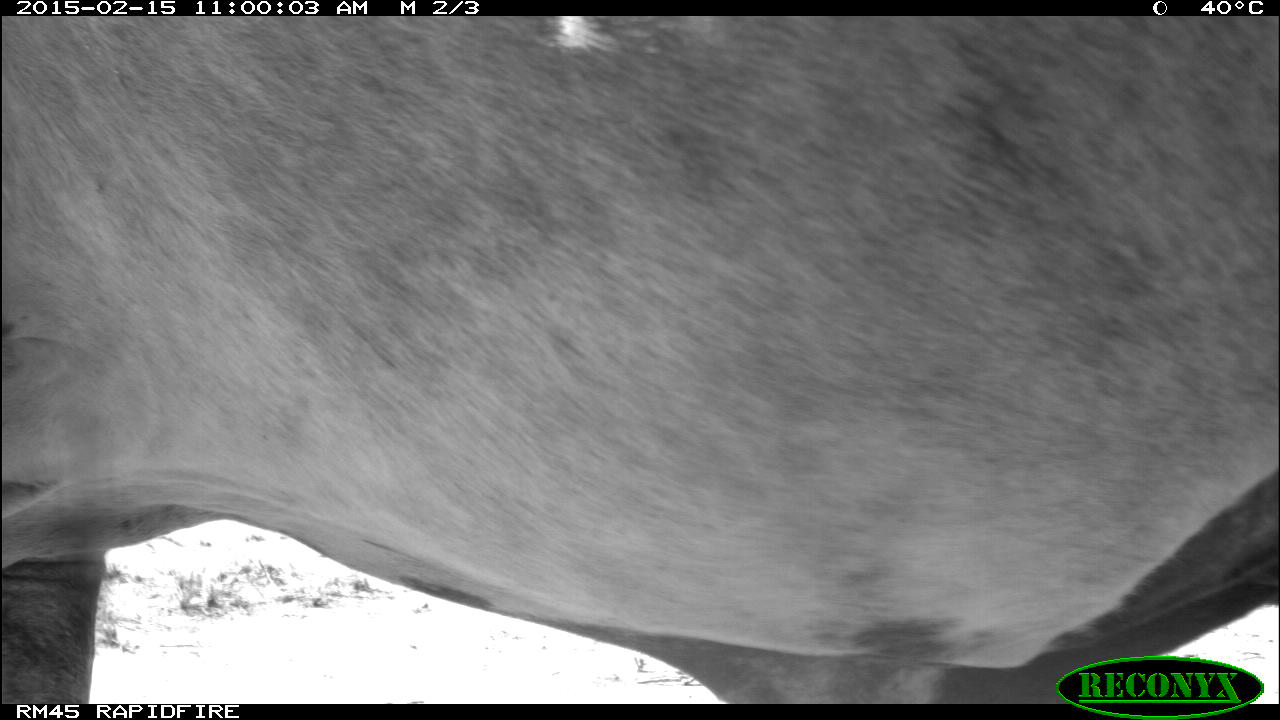

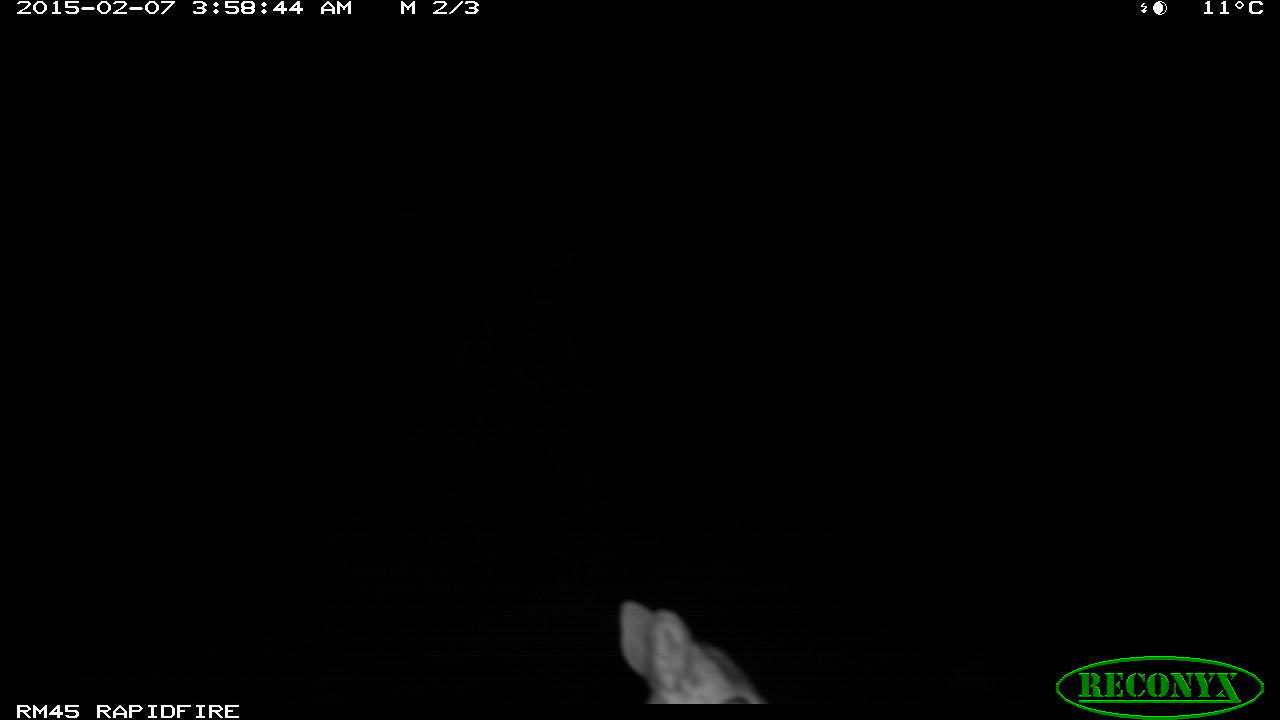

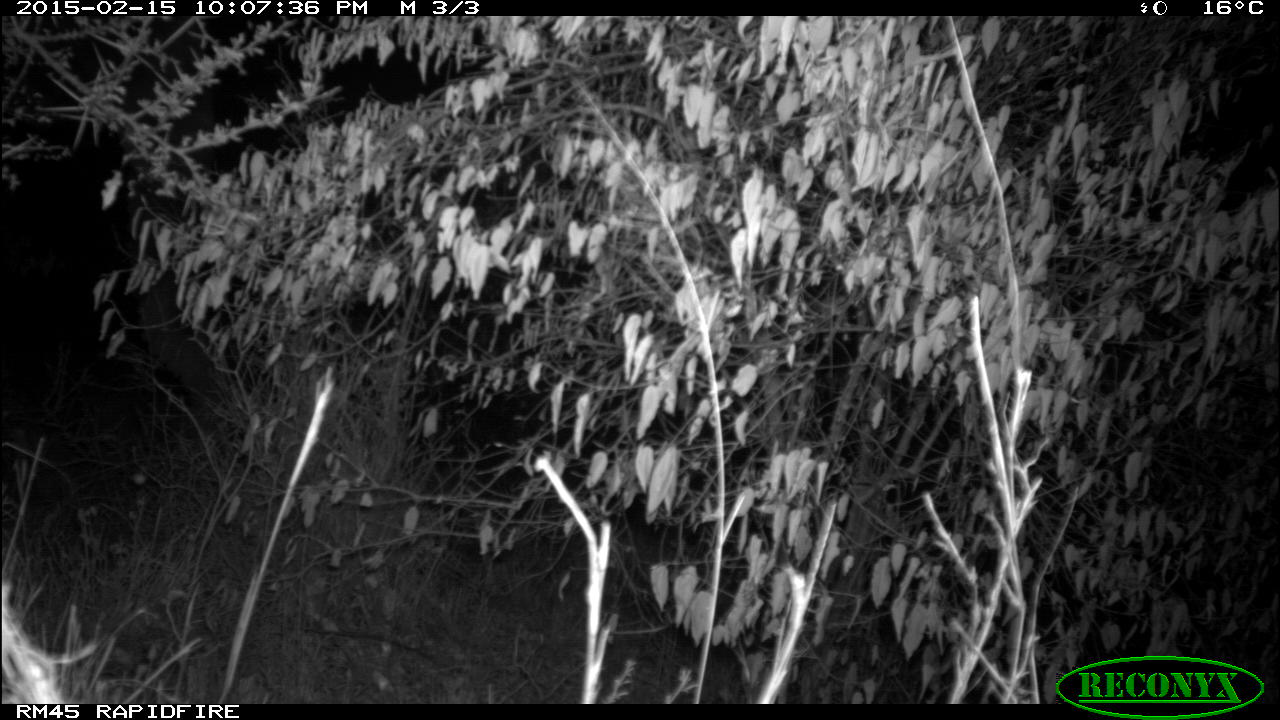

In [45]:
mse_loss = lambda x,y: ((x-y)**2).mean()
mse = 0
showFirst = True
for (images, labels) in test_loader:
    data = model(images)
    if showFirst:
        data.show()
        showFirst = False
    y_pred = np.array([dataframe[dataframe['confidence'] > 0.5].shape[0] for dataframe in data.pandas().xyxy])
    y_true = np.array([len(bboxes) for bboxes in parse_bbox_tuple(labels)])
    mse += mse_loss(y_true, y_pred)

In [48]:
f"MSE is: {mse} for {len(test_data)} images"

'MSE is: 126.30000000000004 for 602 images'

# Preprocess dataset

In [9]:
def convert_str_to_list(str_list):
    res_list = []
    i = 1
    while i < len(str_list):
        start = 0
        if str_list[i]=='[':
            start = i+1
            while str_list[i]!=']':
                i+=1
            end = i

            if start!=end:
                res_list.append(list( 
                                map(float,
                                str_list[start:end].split(', ')) 
                            ))
        i+=1
    return res_list

#convert_str_to_list(df['box'][100])

In [10]:
def load_labels(path,image_name,bbox_list):
    label_file_name = image_name.split('.')[0] + '.txt'
    with open(path+label_file_name,'w') as f:
        for l in bbox_list:
            line = "90"

            for i in l:
                line = line+" "+ str(i)
            f.write(line)
            f.write("\n")

In [11]:
def process_label(df,idx,train=True):
    path = None
    if train:
        path = './dataset/labels/train/'
    else:
        path = './dataset/labels/val/'
        
    bbox = convert_str_to_list(df['box'][idx])
    load_labels(path, df['file_name'][idx],bbox)

In [12]:
def check_image(path):
    with open(path, 'rb') as f:
        check_chars = f.read()[-2:]
    return  check_chars == b'\xff\xd9'

In [13]:
def process_image(df,idx,init_folder,dest_folder):
    
    f_name = df['file_name'][idx]
    if os.path.isfile(f'./{init_folder}/{f_name}') and check_image(f'./{init_folder}/{f_name}'):
        os.system(f'cp ./{init_folder}/{f_name} ./dataset/images/{dest_folder}/{f_name}')
        return True
    return False

In [14]:
"""
Load images to directory: /dataset/images/train/ 
                          /dataset/images/test/ 
                          /dataset/images/val/
"""
def process_dataset(train_size, val_size, test_size):
    #with open("logger.txt",'w') as f:
    #    f.write('')
        
    #Train
    df = pd.read_csv('processed_train.csv', sep='\t', index_col=0)
    
    i = 0
    while train_size>0:
        res = process_image(df,i,init_folder = 'train1/train',dest_folder = 'train')
        if res:
            process_label(df,i,train=True)
            train_size-=1
        else:
            with open("logger.txt",'a') as f:
                f.write(df['file_name'][i])
        i += 1
        
        
    #Val
    while val_size>0:
        if process_image(df,i,init_folder = 'train1/train',dest_folder = 'val'):
            process_label(df,i,train=False)
            val_size-=1
        else:
            
            with open("logger.txt",'a') as f:
                f.write(df['file_name'][i])
        i+=1
        
    #Test
    i = 0
    df1 = pd.read_csv('processed_test.csv', sep='\t', index_col=0)
    while test_size>0:
        
        if process_image(df1,i,init_folder = 'test',dest_folder = 'test'):
            test_size-=1
            
        else:
            with open("logger.txt",'a') as f:
                f.write(df['file_name'][i])
        i+=1
            

In [18]:
!rm /media/danil-pass123/'Новый том'/DataSet/dataset/images/train/*
!rm /media/danil-pass123/'Новый том'/DataSet/dataset/images/test/*
!rm /media/danil-pass123/'Новый том'/DataSet/dataset/images/val/*
!rm /media/danil-pass123/'Новый том'/DataSet/dataset/labels/train/*
!rm /media/danil-pass123/'Новый том'/DataSet/dataset/labels/test/*

rm: невозможно удалить '/media/danil-pass123/Новый том/DataSet/dataset/labels/test/*': Нет такого файла или каталога


In [19]:
#process_dataset(2000,200,500)
process_dataset(100,10,20)

# Model

## Train

In [23]:
!pwd

/media/danil-pass123/Новый том/DataSet


In [24]:
!ls

archives			     not_found.txt
dataset				     processed_test.csv
dataset.zip			     processed_train.csv
data.yaml			     runs
gps_locations.json		     test
iwildcam2022_mdv4_detections.json    train
iwildcam2022_test_information.json   train1
iwildcam2022_train_annotations.json  train_sequence_counts.csv
label1223.txt			     yolov5
logger.txt			     yolov5s.pt


In [ ]:
#/media/danil-pass123/Новый том/DataSet
data_path = '/media/danil-pass123/Новый том/DataSet/data.yaml'
#data_path = 'data.yaml'
train.run(data = data_path,epochs = 20,batch_size=10,single_cls= True,optimizer="SGD",noplots=False,tensorboard=True,workers=2)

train: weights=yolov5/yolov5s.pt, cfg=, data=/media/danil-pass123/Новый том/DataSet/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=True, optimizer=SGD, sync_bn=False, workers=2, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, tensorboard=True
github: ⚠️ YOLOv5 is out of date by 6 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-231-g0039870 Python-3.8.8 torch-1.12.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, c

## Test

In [33]:
import shutil
shutil.rmtree('runs')

In [66]:
test_images = []
test_labels = []
data_path = '/media/danil-pass123/"Новый том"/DataSet/data.yaml'

weights = "./yolov5/runs/train/exp19/weights/best.pt"
weights = 'yolov5/yolov5s.pt'

source = '/media/danil-pass123/Новый том/DataSet/dataset/images/test/'

for i,img in enumerate(os.listdir(source)):
    img_path = source +'/'+img
    detect.run(weights = weights,source = img_path, project = "./runs/",name = f"iter{i}",save_txt=True)
    test_images.append(f'./runs/iter{i}/{img}')
    test_labels.append(f'./runs/iter{i}/labels/{img.split(".")[0]}.txt')

YOLOv5 🚀 v6.2-231-g0039870 Python-3.8.8 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /media/danil-pass123/Новый том/DataSet/dataset/images/test/8b31d3be-21bc-11ea-a13a-137349068a90.jpg: 512x640 1 bird, 163.5ms
Speed: 1.1ms pre-process, 163.5ms inference, 0.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/iter03
1 labels saved to runs/iter03/labels
YOLOv5 🚀 v6.2-231-g0039870 Python-3.8.8 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /media/danil-pass123/Новый том/DataSet/dataset/images/test/8cf202be-21bc-11ea-a13a-137349068a90.jpg: 512x640 1 bird, 173.9ms
Speed: 1.3ms pre-process, 173.9ms inference, 0.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/iter13
1 labels saved to runs/iter13/labels


In [67]:
def draw_images(pos):
    global test_images
    if pos < len(test_images):
        plt.imshow(cv2.imread(test_images[pos]))
    else:
        return


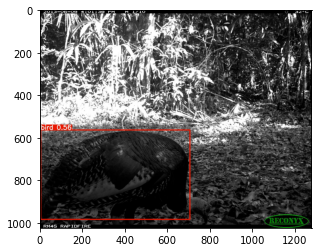

In [94]:
draw_images(0)

In [91]:
def get_true_labels(file_name):
    box_pred = []
    with open(file_name,'r') as f:
        lns = f.readlines()
        
        for l in lns:
            box_pred.append(list(map(float,l.split(' ')))[1:])
    return (box_pred)

def get_real_lables(img_name):
    return convert_str_to_list ( df1[df1['file_name'] ==img_name]['box'][0])[0]

In [92]:
def mse_labels(pos):
    global test_labels,test_images
    df1 = pd.read_csv('processed_test.csv', sep='\t', index_col=0)
    if pos < len(test_images):
        label_name = test_labels[pos]
        box_true = get_true_labels(label_name)
        
        img_name = test_images[0].split('/')[-1]
        box_real = get_real_lables(img_name)
        
        val = 0
        for y_true,y_real in zip(box_true,box_real):
            val += ((np.array(y_true) - np.array(y_real))**2).sum()
        return val
    else:
        return

In [93]:
mse_labels(0)

1.1153465239629998

# Model 2

In [1]:
#!mkdir cfg
#!cd cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2022-11-10 03:34:04--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 8342 (8,1K) [text/plain]
Сохранение в: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8,15K  --.-KB/s    за 0s      

2022-11-10 03:34:05 (24,6 MB/s) - ‘yolov3.cfg’ сохранён [8342/8342]



# Models links

https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html

https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/



In [2]:
import configparser

In [3]:
from collections import OrderedDict

class multidict(OrderedDict):
    _unique = 0   # class variable

    def __setitem__(self, key, val):
        if isinstance(val, dict):
            self._unique += 1
            key += str(self._unique)
        OrderedDict.__setitem__(self, key, val)

In [4]:
#from werkzeug.datastructures import MultiDict

In [5]:
config = configparser.ConfigParser(strict=False,dict_type=multidict)
config.read('yolov3.cfg')

['yolov3.cfg']

In [18]:
config.items('convolutional5')#,config.items('convolutional2')[0][1]

[('batch_normalize', '1'),
 ('filters', '64'),
 ('size', '3'),
 ('stride', '1'),
 ('pad', '1'),
 ('activation', 'leaky')]

In [77]:
for i in config.sections():
    print(i,config.items(i))

net1 [('batch', '64'), ('subdivisions', '16'), ('width', '608'), ('height', '608'), ('channels', '3'), ('momentum', '0.9'), ('decay', '0.0005'), ('angle', '0'), ('saturation', '1.5'), ('exposure', '1.5'), ('hue', '.1'), ('learning_rate', '0.001'), ('burn_in', '1000'), ('max_batches', '500200'), ('policy', 'steps'), ('steps', '400000,450000'), ('scales', '.1,.1')]
convolutional2 [('batch_normalize', '1'), ('filters', '32'), ('size', '3'), ('stride', '1'), ('pad', '1'), ('activation', 'leaky')]
convolutional3 [('batch_normalize', '1'), ('filters', '64'), ('size', '3'), ('stride', '2'), ('pad', '1'), ('activation', 'leaky')]
convolutional4 [('batch_normalize', '1'), ('filters', '32'), ('size', '1'), ('stride', '1'), ('pad', '1'), ('activation', 'leaky')]
convolutional5 [('batch_normalize', '1'), ('filters', '64'), ('size', '3'), ('stride', '1'), ('pad', '1'), ('activation', 'leaky')]
shortcut6 [('from', '-3'), ('activation', 'linear')]
convolutional7 [('batch_normalize', '1'), ('filters',

In [ ]:
def parse_cfg(cfgfile):
    """
    Takes a configuration file
    
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list
    
    """
    
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    
    return blocks


In [ ]:
def create_conv():
        

In [ ]:
def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing    
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []
    
    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()
    
        #check the type of block
        #create a new module for the block
        #append to module_list
        
        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
        
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
        
            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
        
            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)
        
            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
        
            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
            #If it's an upsampling layer
            #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)
                
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]
    
        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)
